# Pairwise MLP with PU

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- cone around the candidate trackster


## MLP

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from reco.loss import FocalLoss

from reco.datasetPU import TracksterPairsPU


ds_name = "CloseByGamma200PU"
data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
ds = TracksterPairsPU(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=10
)

ds.x.shape

Processing: /Users/ecuba/data/CloseByGamma200PU/new_ntuples_15295178_26.root
Processing: /Users/ecuba/data/CloseByGamma200PU/new_ntuples_15295178_21.root
Processing: /Users/ecuba/data/CloseByGamma200PU/new_ntuples_15295178_20.root
Processing: /Users/ecuba/data/CloseByGamma200PU/new_ntuples_15295178_23.root
Processing: /Users/ecuba/data/CloseByGamma200PU/new_ntuples_15295178_2.root
Processing: /Users/ecuba/data/CloseByGamma200PU/new_ntuples_15295178_22.root
Processing: /Users/ecuba/data/CloseByGamma200PU/new_ntuples_15295178_29.root
Processing: /Users/ecuba/data/CloseByGamma200PU/new_ntuples_15295178_25.root
Processing: /Users/ecuba/data/CloseByGamma200PU/new_ntuples_15295178_24.root
Processing: /Users/ecuba/data/CloseByGamma200PU/new_ntuples_15295178_28.root


torch.Size([5915, 43])

In [4]:
scaler = StandardScaler()
scaler.fit(ds.x)
ds.x = torch.tensor(scaler.transform(ds.x)).type(torch.float)

In [5]:
print(ds.x.shape)
print("Positive:", int((ds.y > 0.5).type(torch.int).sum()))
print("Negative:", int((ds.y < 0.5).type(torch.int).sum()))

torch.Size([5915, 31])
Positive: 362
Negative: 5553


In [6]:
balance =  float(sum(ds.y) / len(ds.y))
print(f"dataset balance: {balance*100:.2f}% / {(1-balance)*100:.2f}%") 

dataset balance: 8.98% / 91.02%


In [7]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

Train samples: 5324, Test samples: 591


In [37]:
def train(model, opt, loader, loss_obj):
    epoch_loss = 0
    for batch, labels in loader:
        # reset optimizer and enable training mode
        opt.zero_grad()
        model.train()

        # move data to the device
        batch = batch.to(device)
        labels = labels.to(device)
        
        # get the prediction tensor
        z = model(batch).reshape(-1)

        # compute the loss
        loss = loss_obj(z, labels)        
        epoch_loss += loss

        # back-propagate and update the weight
        loss.backward()
        opt.step()

    return float(epoch_loss)

@torch.no_grad()
def test(model, data):
    total = 0
    correct = 0
    for batch, labels in data:
        model.eval()
        batch = batch.to(device)
        labels = labels.to(device)
        z = model(batch).reshape(-1)
        prediction = (z > 0.5).type(torch.int)
        labels_acc = (labels > 0.5).type(torch.int)
        total += len(prediction) 
        correct += sum(prediction == labels_acc)
    return (correct / total)

In [42]:
model = nn.Sequential(
    nn.Linear(ds.x.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Dropout(p=0.2),
    nn.Sigmoid()
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
loss_obj = FocalLoss(alpha=1-balance, gamma=2)

epochs = 101

for epoch in range(epochs):
    loss = train(model, optimizer, train_dl, loss_obj)
    train_acc = test(model, train_dl)
    test_acc = test(model, test_dl)
    scheduler.step()
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}')

Epoch: 0, loss: 0.5308, train acc: 0.9393, test acc: 0.9340
Epoch: 5, loss: 0.2709, train acc: 0.9677, test acc: 0.9645
Epoch: 10, loss: 0.2356, train acc: 0.9750, test acc: 0.9645
Epoch: 15, loss: 0.2305, train acc: 0.9780, test acc: 0.9662
Epoch: 20, loss: 0.2148, train acc: 0.9837, test acc: 0.9645
Epoch: 25, loss: 0.2063, train acc: 0.9853, test acc: 0.9662
Epoch: 30, loss: 0.2215, train acc: 0.9867, test acc: 0.9628
Epoch: 35, loss: 0.2047, train acc: 0.9878, test acc: 0.9679
Epoch: 40, loss: 0.2054, train acc: 0.9885, test acc: 0.9662
Epoch: 45, loss: 0.1926, train acc: 0.9891, test acc: 0.9645
Epoch: 50, loss: 0.2157, train acc: 0.9897, test acc: 0.9679
Epoch: 55, loss: 0.2021, train acc: 0.9900, test acc: 0.9628
Epoch: 60, loss: 0.2027, train acc: 0.9904, test acc: 0.9662
Epoch: 65, loss: 0.2030, train acc: 0.9912, test acc: 0.9611
Epoch: 70, loss: 0.2008, train acc: 0.9902, test acc: 0.9645
Epoch: 75, loss: 0.2024, train acc: 0.9923, test acc: 0.9645
Epoch: 80, loss: 0.1776, t

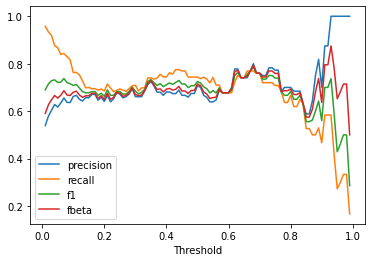

In [43]:
th_values = [i / 100. for i in range(1, 100)]
precision = []
recall = []
f1scores = []
fbeta = []

for th in th_values:
    pred = []
    lab = []
    for b, l in test_dl:
        b = b.to(device)
        l = l.to(device)
        pred += (model(b) > th).type(torch.int).tolist()
        lab += (l > th).type(torch.int).tolist()
    precision.append(precision_score(lab, pred, zero_division=0))
    recall.append(recall_score(lab, pred))
    f1scores.append(f1_score(lab, pred))
    fbeta.append(fbeta_score(lab, pred, beta=0.5))

plt.figure()
plt.plot(th_values, precision, label="precision")
plt.plot(th_values, recall, label="recall")
plt.plot(th_values, f1scores, label="f1")
plt.plot(th_values, fbeta, label="fbeta")
plt.xlabel("Threshold")
plt.legend()
plt.show()

In [47]:
decision_th = th_values[np.argmax(fbeta)]

pred = []
lab = []
for b, l in test_dl:
    b = b.to(device)
    l = l.to(device)
    pred += (model(b) > decision_th).type(torch.int).tolist()
    lab += (l > th).tolist()

tn, fp, fn, tp = confusion_matrix(lab, pred).ravel()
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
acc = accuracy_score(lab, pred)
precision = precision_score(lab, pred)
recall = recall_score(lab, pred)
f1 = f1_score(lab, pred)
fb = fbeta_score(lab, pred, beta=0.5)
print(f'TH: {decision_th} Acc: {acc:.3f} P: {precision:.3f} R: {recall:.3f} F1: {f1:.3f} FB: {fb:.3f}')

TP: 5, TN: 583, FP: 2, FN: 1
TH: 0.93 Acc: 0.995 P: 0.714 R: 0.833 F1: 0.769 FB: 0.735


# Evaluation

Give the model a list of candidate edges to evaluate.
Reconstruct the event and evaluate against ground truth. 

In [4]:
import uproot
import numpy as np
from reco.evaluation import evaluate

file_name = f"{raw_dir}/new_ntuples_15295178_22.root"
tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

In [50]:
evaluate()